In [6]:
import numpy as np
import pandas as pd
import matplotlib as plt

In [46]:
df = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\gpDeepCut_resnet50_goprofrontviewJun17shuffle1_30001.h5")
#remove extra level "scorer"
df.columns = df.columns.droplevel()
df.describe()

bodyparts       leftEar                                  rightEar  \
coords                x             y    likelihood             x   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         418.129470    104.092916      0.819854    342.438231   
std           59.484658     55.269955      0.345757     61.201473   
min           -0.232820      0.058952      0.000652      1.185614   
25%          410.203378     75.918766      0.963633    317.790530   
50%          431.752412    109.551635      0.999844    332.283849   
75%          443.193016    141.584548      0.999973    346.850670   
max          651.580333    398.199630      0.999999    609.912476   

bodyparts                                      Nose                \
coords                y    likelihood             x             y   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         101.684238      0.801598    375.327111    208.523040   
std           58.679316      0.350441     59.976627     70.090319   
min           -2.496538      0.001448      0.344874     18.644475   
25%           64.836136      0.799568    366.916633    149.775522   
50%          103.500209      0.999885    382.856600    222.712812   
75%          142.310630      0.999981    389.395545    261.157506   
max          346.226936      0.999999    623.018394    397.013597   

bodyparts                    leftHand      ...          rightHand  \
coords       likelihood             x      ...         likelihood   
count      24320.000000  24320.000000      ...       24320.000000   
mean           0.789948    401.102718      ...           0.459706   
std            0.335402     42.124632      ...           0.409989   
min            0.002590     64.313986      ...           0.001246   
25%            0.663167    382.997393      ...           0.045521   
50%            0.996328    403.306821      ...           0.325276   
75%            0.999806    426.271711      ...           0.952850   
max            0.999998    652.821492      ...           0.999980   

bodyparts      leftFoot                                 rightFoot  \
coords                x             y    likelihood             x   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         400.000369    211.809658      0.563731    325.880319   
std          106.976893     68.213118      0.431094     36.197824   
min           70.790897      4.613057      0.002174      1.576407   
25%          395.883299    152.843292      0.087321    305.209249   
50%          438.449283    214.538742      0.681825    319.431005   
75%          455.452176    224.842714      0.999839    335.237931   
max          654.890787    395.073073      0.999997    646.668256   

bodyparts                                    pellet                \
coords                y    likelihood             x             y   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         193.638297      0.801919    391.551464    295.535599   
std           42.793461      0.327147     38.246815     62.200636   
min            1.647910      0.003355      1.279912      0.627747   
25%          152.980904      0.679855    392.289892    267.040393   
50%          211.355771      0.997711    395.490041    325.472089   
75%          224.876223      0.999907    397.825792    335.043683   
max          396.876828      0.999999    641.452611    395.651502   

bodyparts                
coords       likelihood  
count      24320.000000  
mean           0.634827  
std            0.460287  
min            0.001884  
25%            0.025175  
50%            0.999050  
75%            0.999830  
max            0.999988  

[8 rows x 24 columns]

In [144]:
def frame_to_time(frame):
    total_seconds = (frame/24320)*202
    return round(total_seconds, 3)
def time_to_frame(time):
    return 24320*(time/202)

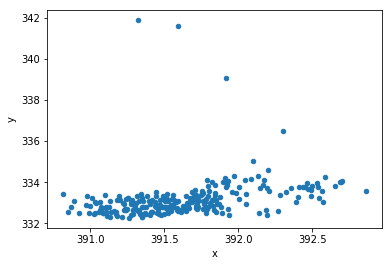

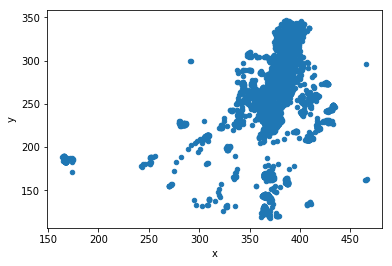

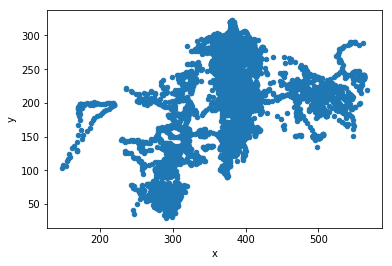

In [145]:
labels = {key: df[df[key, 'likelihood'] > 0.9][key] for key in list(df.columns.levels[0])}
{labels[key].insert(0, "frame", labels[key].index, True) for key in labels.keys()}
{labels[key].insert(0, "time", labels[key]['frame'].map(frame_to_time), True) for key in labels.keys()}
leftEar = labels['leftEar']
rightEar = labels['rightEar']
nose = labels['Nose']
leftHand = labels['leftHand']
rightHand = labels['rightHand']
leftFoot = labels['leftFoot']
rightFoot = labels['rightFoot']
pellet = labels['pellet']
pellet[(pellet['time'] > 22.5) & (pellet['time'] < 25)].plot(kind='scatter', x='x', y='y')
rightHand.plot(kind='scatter', x='x', y='y')
nose.plot(kind='scatter', x='x', y='y')

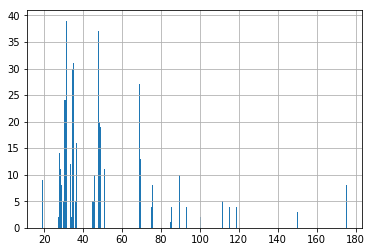

In [146]:
def dist_from_dispenser(x, y):
    return ((x-405)**2 + (y-347.5)**2)**0.5
rightHand['d_from_dispenser'] = rightHand.apply(lambda row: dist_from_dispenser(x = row['x'], y = row['y']), axis=1)
hand_reach2 = rightHand[rightHand['d_from_dispenser'] < 35]
hand_reach2['time'].hist(bins=300)


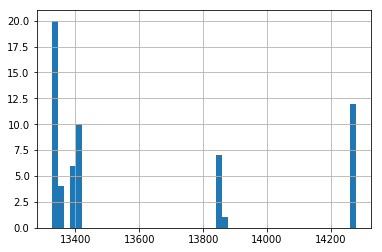

In [147]:
hand_reach2 = rightHand[(rightHand['d_from_dispenser'] < 45)& (rightHand['time'] < 120) & (rightHand['time'] > 109)]
hand_reach2['frame'].hist(bins=50)

In [166]:
hand_reach2 = rightHand[rightHand['d_from_dispenser'] < 40]
def get_reaches():
    reaches = []
    last_frame = hand_reach2['frame'].values[0]
    consec_frames_ct = 1 #number of consecutive frames
    first_frame_of_reach = last_frame
    for frame in hand_reach2['frame'].values:
        if (frame - last_frame < 10):
            consec_frames_ct += 1
        else:
            reaches.append((first_frame_of_reach, consec_frames_ct))
            consec_frames_ct = 1
            first_frame_of_reach = frame
        last_frame = frame
    reaches.append((first_frame_of_reach, consec_frames_ct))
    
    #filter out false positives: reaches that only lasted 2 frames
    reaches2 = [x for x in reaches if x[1] > 3]
    reaches2_time = [(frame_to_time(x[0]), frame_to_time(x[1])) for x in reaches2]
    return reaches2_time
get_reaches()

[(18.938, 0.091),
 (27.434, 0.075),
 (28.157, 0.233),
 (28.722, 0.282),
 (30.35, 0.274),
 (30.981, 0.449),
 (33.431, 0.15),
 (34.088, 0.266),
 (34.827, 0.772),
 (36.172, 0.141),
 (44.96, 0.125),
 (45.658, 0.166),
 (47.701, 0.341),
 (48.457, 0.357),
 (51.073, 0.116),
 (68.507, 0.257),
 (69.138, 0.166),
 (75.144, 0.05),
 (75.592, 0.108),
 (84.554, 0.033),
 (85.119, 0.108),
 (89.629, 0.133),
 (93.151, 0.058),
 (100.493, 0.042),
 (110.693, 0.042),
 (111.308, 0.066),
 (114.979, 0.05),
 (118.534, 0.05),
 (146.001, 0.033),
 (149.905, 0.042),
 (175.305, 0.075)]

In [178]:
bat_file= r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\{}_create_videos.bat".format(project_name)
project_name = "goprofrontview"
time_log= open(bat_file,"a+")
for tpl in get_reaches():
    cmd = "ffmpeg -i gp.mp4 -ss {0} -t {1} -c copy cut_video.mp4".format()
    time_log.write(cmd)
time_log.close()
                                               

In [182]:
def seconds_formatter(seconds):
    hours = seconds//3600
    minutes = (seconds%3600)//60
    seconds = (seconds%60)//1
    milliseconds = seconds
    print(hours)
    print(minutes)
    print(seconds)
    print(milliseconds)
seconds_formatter(34.827)

0.0
0.0
34.0
0.0


In [8]:
above_lkh[(df['Nose', "likelihood"] >= 0.1)]['Nose'].plot(kind='scatter', x='x', y='y')
df['Nose'].head()
above_lkh['Nose'].plot.line()

C:\Users\vjj14\.conda\envs\dlc-windowsGPU\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [9]:
df.head()

bodyparts     LeftHand                           RightHand              \
coords               x            y likelihood           x           y   
0          1390.192226   863.416119   0.002139  655.710966  671.552855   
1          1342.686916  1022.539194   0.002778  655.604768  672.732703   
2          1378.603021   839.200051   0.047292  655.568096  671.990225   
3           717.164830   528.112061   0.003874  713.522496  529.766140   
4          1342.347172  1021.188973   0.002228  772.206697  391.288171   

bodyparts                    Nose                             Pellet  \
coords    likelihood            x           y likelihood           x   
0           0.032500   858.313563  502.588775   0.008193  780.110655   
1           0.014964   858.805179  503.061315   0.009881  780.056775   
2           0.008627  1376.614242  838.820607   0.023861  779.368590   
3           0.013523   712.549768  530.312717   0.013139  779.937964   
4           0.004997   776.260397  387.588437   0.016647  781.683410   

bodyparts                         
coords              y likelihood  
0          385.511159   0.005372  
1          385.812507   0.004218  
2          384.613344   0.005453  
3          384.928218   0.008758  
4          385.065720   0.030118

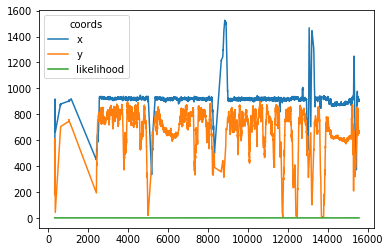

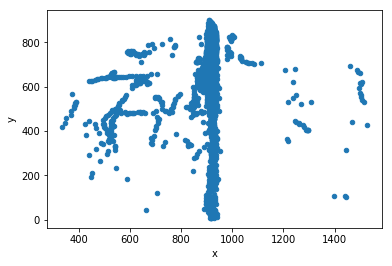

In [10]:
variablename = 0.8
above_lkh_nose = above_lkh[(above_lkh['Nose', 'likelihood'] >= variablename)]['Nose']
above_lkh_nose.plot()
above_lkh_nose.plot(kind='scatter', x='x', y='y')

In [11]:
print(above_lkh_nose.describe())
nose_diff= above_lkh_nose.diff()
nose_diff.describe()

coords             x             y    likelihood
count   10288.000000  10288.000000  10288.000000
mean      908.911847    699.993643      0.952286
std        63.579013    133.992409      0.043337
min       334.469009      7.905138      0.800098
25%       911.657064    632.673547      0.937604
50%       918.253522    729.451098      0.968311
75%       923.832225    799.441160      0.982928
max      1525.848711    898.827847      0.997645


coords,x,y,likelihood
count,10287.000000,10287.000000,10287.000000
mean,0.030858,0.047538,0.000005
std,21.501668,19.964920,0.049270
min,-762.730662,-551.037407,-0.183404
25%,-2.970357,-5.943775,-0.019500
50%,-0.028691,-0.179610,0.000170
75%,2.862602,5.436313,0.019998
max,925.877482,628.866126,0.181662


In [12]:
print(list(nose_diff.columns))
test = nose_diff.copy()
for i in range(len(nose_diff.columns)):
    x = nose_diff.columns[i]
    test = test.loc[(test[x] < 50) & (test[x] > -50)]
test.describe()

['x', 'y', 'likelihood']


coords,x,y,likelihood
count,10159.000000,10159.000000,10159.000000
mean,-0.067206,-0.139637,-0.000016
std,5.322679,12.705114,0.049041
min,-48.878414,-49.734086,-0.183404
25%,-2.927772,-5.858834,-0.019375
50%,-0.033396,-0.192833,0.000168
75%,2.819060,5.276144,0.019755
max,43.036841,49.725568,0.181662


In [13]:
x = test.unstack(0)
y = list(test.index)
print(y[-1])
nose_diff.describe()

15555


coords,x,y,likelihood
count,10287.000000,10287.000000,10287.000000
mean,0.030858,0.047538,0.000005
std,21.501668,19.964920,0.049270
min,-762.730662,-551.037407,-0.183404
25%,-2.970357,-5.943775,-0.019500
50%,-0.028691,-0.179610,0.000170
75%,2.862602,5.436313,0.019998
max,925.877482,628.866126,0.181662


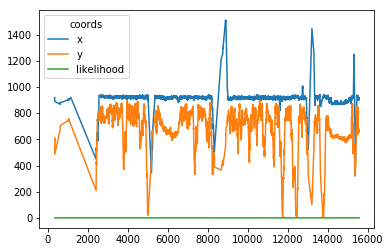

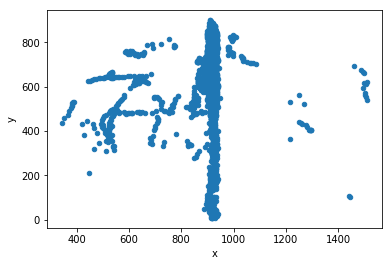

In [35]:
diditwork = df.iloc[y]
diditwork_nose = diditwork[diditwork['Nose', 'likelihood'] >= variablename]['Nose']
diditwork_nose.plot()
diditwork_nose.plot(kind='scatter', x='x', y='y')

In [1]:
step=200
for i in range(0, len(diditwork_nose.index), step):
    diditwork_nose[i:i+step].plot(kind='scatter', x='x', y='y', c=diditwork_nose.index[i:i+step], colormap='viridis')    

NameError: name 'diditwork_nose' is not defined

In [86]:
def frames_to_time(frame):
    total_seconds = (frame/15562)*518
    return (total_seconds//60, total_seconds%60)
print(frames_to_time(6850))
print(frames_to_time(12900))
#5000 to 54000
#12900 to 13400

(3.0, 48.01053849119651)
(7.0, 9.392108983421167)


In [36]:
with_index = diditwork_nose.insert(0, "frame", diditwork_nose.index, True)
diditwork_nose

coords,frame,x,y,likelihood
348,348,918.060742,586.062276,0.914259
349,349,910.986737,601.974144,0.965118
350,350,911.701995,601.754704,0.982928
351,351,909.769525,611.335683,0.984632
352,352,910.553169,583.690089,0.928573
354,354,897.131166,513.520042,0.878070
355,355,889.593034,486.007793,0.930536
620,620,867.244447,674.338127,0.895262
622,622,882.065659,682.048440,0.824874
628,628,879.397736,705.390579,0.841225


In [42]:
def filter_func(x, y):
    return y > ((-4/3)*x + 2400)

In [54]:
test_filter = diditwork_nose[diditwork_nose.apply(lambda x: x['y'] > ((-4/3)*x['x'] + 2400), axis=1)]
test_filter

coords,frame,x,y,likelihood
8886,8886,1508.573401,540.781979,0.963970
8887,8887,1505.409532,551.789615,0.920899
8888,8888,1501.967117,559.717389,0.902986
8889,8889,1501.364138,572.545012,0.841390
8891,8891,1494.497715,595.348415,0.907974
8894,8894,1499.957923,613.780645,0.833412
8895,8895,1504.696020,613.385324,0.840762
8896,8896,1508.822270,619.573763,0.847669
8902,8902,1498.986671,659.541386,0.866306
8903,8903,1493.765005,664.423945,0.825519


coords,frame,x,y,likelihood
2670,2670,916.278932,1061.855119,0.979140
2684,2684,944.268069,1053.620954,0.962063
2685,2685,944.271519,1051.856337,0.963501
2687,2687,942.616974,1046.428902,0.981420
2688,2688,939.977617,1044.536356,0.977153
2689,2689,942.136828,1039.412585,0.981396
2690,2690,942.286657,1036.906953,0.984402
2691,2691,941.605551,1033.828268,0.987381
2692,2692,940.962503,1029.037800,0.989306
2693,2693,944.253856,1025.494226,0.984624


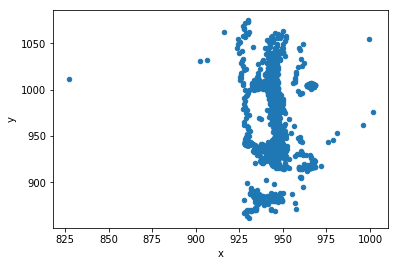

In [73]:
above_lkh_pellet = pellet[pellet['likelihood'] > 0.95]
above_lkh_pellet.plot(kind='scatter', x='x', y='y')
above_lkh_pellet.insert(0, "frame", above_lkh_pellet.index, True)
above_lkh_pellet

coords,frame,x,y,likelihood
2789,2789,934.318640,871.620962,0.953568
2790,2790,934.807077,873.095166,0.956647
2791,2791,934.456243,872.593317,0.964196
2792,2792,934.330187,870.504959,0.956813
2795,2795,933.252661,870.036046,0.978288
2796,2796,934.204376,870.330479,0.963695
2797,2797,932.694907,870.553389,0.952167
2798,2798,931.723292,869.173181,0.958897
2799,2799,931.943863,869.316299,0.969535
2800,2800,933.752392,871.892170,0.963139


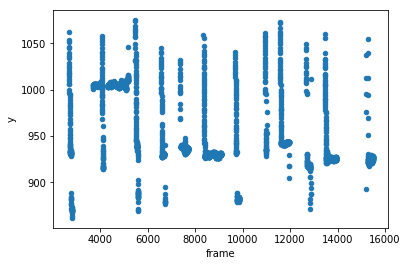

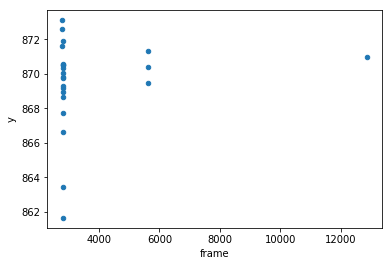

In [87]:
#425
under_900 = above_lkh_pellet[(above_lkh_pellet['y'] < 875)]
above_lkh_pellet.plot(kind='scatter', x='frame', y='y')
under_900.plot(kind='scatter', x='frame', y='y')
under_900

In [ ]:
csv = pd.read_csv(r"C:\Users\vjj14\Desktop\DeepLabCut\frontslowmo-vj-2019-06-05\videos\1080pDeepCut_resnet50_frontslowmoJun5shuffle1_28000.csv")
csv.head()
